Genre Occurrences:
Animation: 1599
Comedy: 11309
Family: 2305
Adventure: 2891
Fantasy: 1866
Romance: 6159
Action: 5584
Crime: 3769
Drama: 18449
Thriller: 6677
History: 1286
Science Fiction: 2455
War: 1183
Mystery: 2156
Foreign: 1501
Music: 1426
Horror: 3707
Documentary: 3641
Western: 905
TV Movie: 679


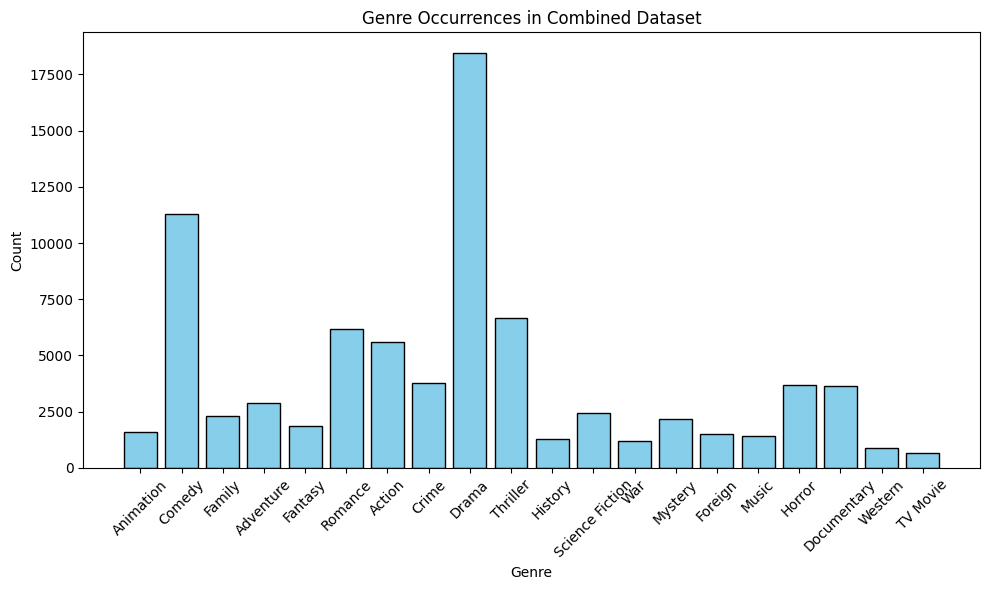

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Read the dataset with pipe delimiter.
data = pd.read_csv("filtered_movies.csv", delimiter="|")

# Process the Genre column: split and strip the genre names.
all_genres = data['Genre'].dropna().apply(lambda x: [g.strip() for g in x.split(',')])
genre_list = [genre for sublist in all_genres for genre in sublist]

# Count occurrences of each genre.
genre_counts = Counter(genre_list)

# Print the number of occurrences for each genre.
print("Genre Occurrences:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

# Prepare lists for plotting.
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

# Plot the bar chart.
plt.figure(figsize=(10, 6))
plt.bar(range(len(genres)), counts, color='skyblue', edgecolor='black')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Occurrences in Combined Dataset')
plt.xticks(range(len(genres)), genres, rotation=45)
plt.tight_layout()
plt.show()

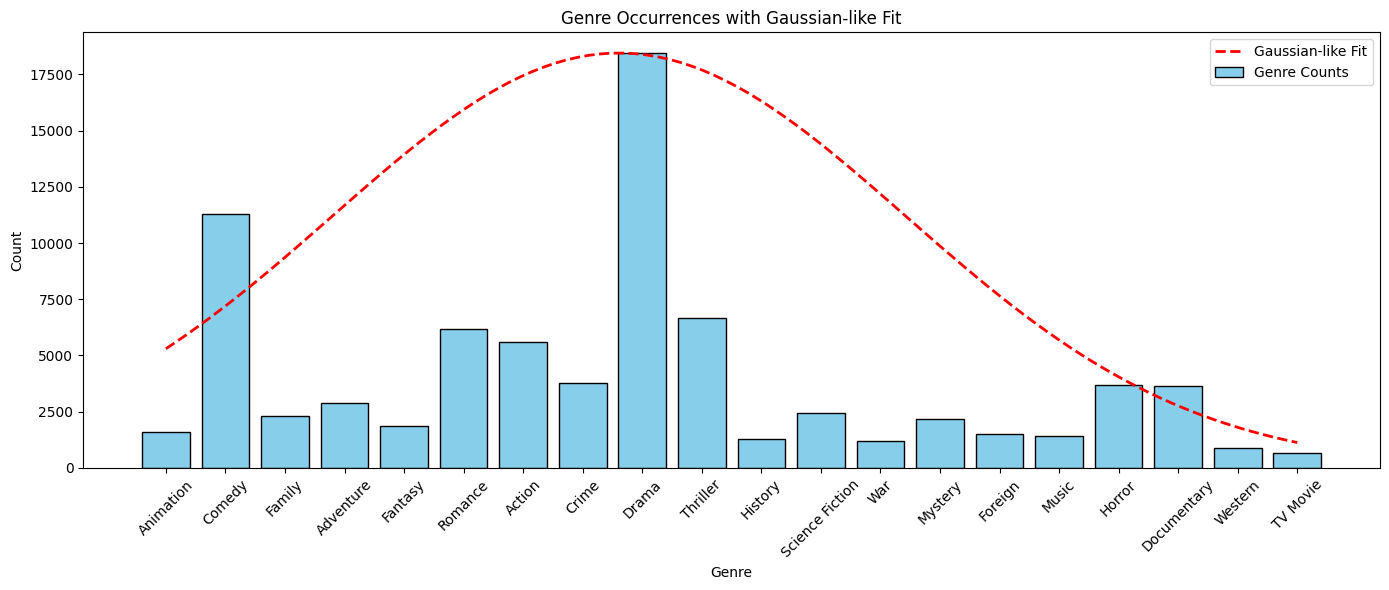

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the genres and their counts (based on your provided data)
genres = [
    "Animation", "Comedy", "Family", "Adventure", "Fantasy", "Romance",
    "Action", "Crime", "Drama", "Thriller", "History", "Science Fiction",
    "War", "Mystery", "Foreign", "Music", "Horror", "Documentary", "Western", "TV Movie"
]
counts = [
    1599, 11309, 2305, 2891, 1866, 6159, 5584, 3769, 18449, 6677,
    1286, 2455, 1183, 2156, 1501, 1426, 3707, 3641, 905, 679
]

# Create x-axis positions for the genres (one per each genre)
indices = np.arange(len(genres))

# Compute the weighted mean and standard deviation over the indices (weighted by counts)
mean_idx = np.average(indices, weights=counts)
std_idx = np.sqrt(np.average((indices - mean_idx)**2, weights=counts))

# Generate x values for the Gaussian curve over the index range
x_curve = np.linspace(indices.min(), indices.max(), 100)
pdf = norm.pdf(x_curve, mean_idx, std_idx)

# Scale the Gaussian so its peak roughly matches the maximum count
scale_factor = max(counts) / max(pdf)
pdf_scaled = pdf * scale_factor

# Plot the bar chart and overlay the Gaussian-like curve.
plt.figure(figsize=(14, 6))
plt.bar(indices, counts, color='skyblue', edgecolor='black', label='Genre Counts')
plt.plot(x_curve, pdf_scaled, 'r--', linewidth=2, label='Gaussian-like Fit')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Occurrences with Gaussian-like Fit')
plt.xticks(indices, genres, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

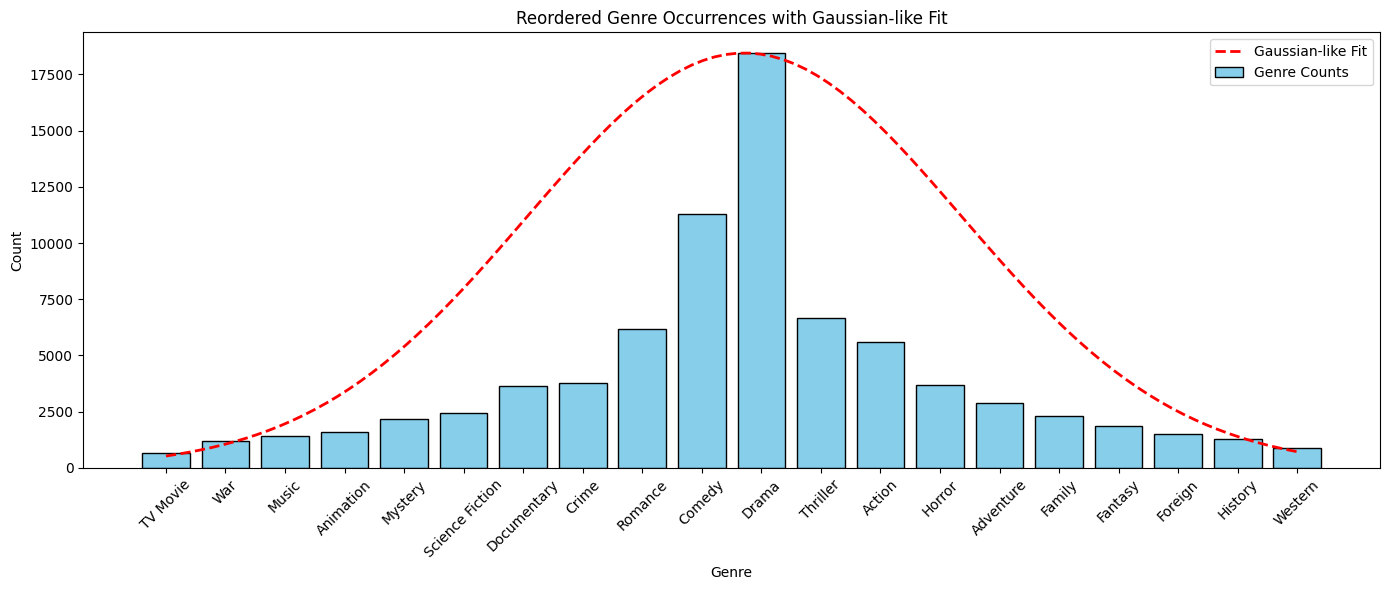

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the genres and their counts (based on your provided data)
genres = [
    "Animation", "Comedy", "Family", "Adventure", "Fantasy", "Romance",
    "Action", "Crime", "Drama", "Thriller", "History", "Science Fiction",
    "War", "Mystery", "Foreign", "Music", "Horror", "Documentary", "Western", "TV Movie"
]
counts = [
    1599, 11309, 2305, 2891, 1866, 6159, 5584, 3769, 18449, 6677,
    1286, 2455, 1183, 2156, 1501, 1426, 3707, 3641, 905, 679
]

# --- Reorder genres so that the maximum count is at the center ---

# Combine genres and counts into tuples and sort descending by count.
genre_counts = list(zip(genres, counts))
genre_counts_sorted = sorted(genre_counts, key=lambda x: x[1], reverse=True)

# Remove the maximum count item to place in the center.
center = genre_counts_sorted.pop(0)

# Alternate the remaining items into left and right lists.
left = []
right = []
toggle = True
for item in genre_counts_sorted:
    if toggle:
        left.append(item)
    else:
        right.append(item)
    toggle = not toggle

# Compose the final ordering: left (reversed) then center then right.
final_order = left[::-1] + [center] + right
final_genres = [g for g, c in final_order]
final_counts = [c for g, c in final_order]

# --- Plotting ---

# Create x-axis positions for the reordered genres.
indices = np.arange(len(final_genres))

# Compute the weighted mean and standard deviation over the indices (weighted by counts).
mean_idx = np.average(indices, weights=final_counts)
std_idx = np.sqrt(np.average((indices - mean_idx)**2, weights=final_counts))

# Generate x values for the Gaussian curve over the index range.
x_curve = np.linspace(indices.min(), indices.max(), 100)
pdf = norm.pdf(x_curve, mean_idx, std_idx)

# Scale the Gaussian so its peak roughly matches the maximum count.
scale_factor = max(final_counts) / max(pdf)
pdf_scaled = pdf * scale_factor

plt.figure(figsize=(14, 6))
plt.bar(indices, final_counts, color='skyblue', edgecolor='black', label='Genre Counts')
plt.plot(x_curve, pdf_scaled, 'r--', linewidth=2, label='Gaussian-like Fit')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Reordered Genre Occurrences with Gaussian-like Fit')
plt.xticks(indices, final_genres, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

LSTM WITH BERT

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
import os

# Set random seed
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Initialize BERT tokenizer (used only for tokenization, not BERT model)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Load and preprocess data
df = pd.read_csv('filtered_movies.csv', sep='|')
df = df.dropna(subset=['Overview', 'Genre'])
df = df[df['Overview'].str.strip() != '']
df = df[df['Genre'].str.strip() != '']
print(f"Dataset size after cleaning: {len(df)} rows")

df['Genre'] = df['Genre'].apply(lambda x: [g.strip() for g in x.split(',')])
mlb = MultiLabelBinarizer()
genre_labels = mlb.fit_transform(df['Genre'])
genre_classes = mlb.classes_
print(f"Genres detected: {list(genre_classes)}")

genre_counts_dict = {
    'Animation': 1599, 'Comedy': 11309, 'Family': 2305, 'Adventure': 2891, 'Fantasy': 1866,
    'Romance': 6159, 'Action': 5584, 'Crime': 3769, 'Drama': 18449, 'Thriller': 6677,
    'History': 1286, 'Science Fiction': 2455, 'War': 1183, 'Mystery': 2156, 'Foreign': 1501,
    'Music': 1426, 'Horror': 3707, 'Documentary': 3641, 'Western': 905, 'TV Movie': 679
}
missing_genres = set(genre_classes) - set(genre_counts_dict.keys())
if missing_genres:
    print(f"Warning: Genres {missing_genres} not in provided counts. Assigning default count of 1.")
    for genre in missing_genres:
        genre_counts_dict[genre] = 1

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(df['Overview'].tolist(), genre_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

# Enhanced oversampling for rare genres
rare_genres_1000 = [g for g, c in genre_counts_dict.items() if c < 1000]  # e.g., TV Movie, Western
rare_genres_2000 = [g for g, c in genre_counts_dict.items() if 1000 <= c < 2000]  # e.g., War, History
rare_indices_1000 = [i for i, labels in enumerate(y_train) if any(mlb.classes_[j] in rare_genres_1000 for j in np.where(labels)[0])]
rare_indices_2000 = [i for i, labels in enumerate(y_train) if any(mlb.classes_[j] in rare_genres_2000 for j in np.where(labels)[0])]

X_train_oversampled = np.concatenate([
    X_train,
    [X_train[i] for i in rare_indices_1000] * 4,  # 5x total (1 original + 4 copies)
    [X_train[i] for i in rare_indices_2000] * 2   # 3x total (1 original + 2 copies)
])
y_train_oversampled = np.concatenate([
    y_train,
    [y_train[i] for i in rare_indices_1000] * 4,
    [y_train[i] for i in rare_indices_2000] * 2
])
print(f"Train size after enhanced oversampling: {len(X_train_oversampled)}")
print(f"Labels size after oversampling: {len(y_train_oversampled)}")
assert len(X_train_oversampled) == len(y_train_oversampled), "Mismatch in oversampled data lengths"

# Tokenize all splits
def tokenize_text(text, max_len=100):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='np'
    )
    return encoding['input_ids'].flatten()

encoded_texts_train = np.array([tokenize_text(text, max_len=100) for text in X_train_oversampled])
encoded_texts_val = np.array([tokenize_text(text, max_len=100) for text in X_val])
encoded_texts_test = np.array([tokenize_text(text, max_len=100) for text in X_test])
print(f"Encoded texts shape (train): {encoded_texts_train.shape}")

# Dataset and DataLoader
class MovieDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        assert len(self.texts) == len(self.labels), "Mismatch between texts and labels lengths"
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return {'text': torch.tensor(self.texts[idx], dtype=torch.long), 'label': torch.tensor(self.labels[idx], dtype=torch.float)}

train_dataset = MovieDataset(encoded_texts_train, y_train_oversampled)
val_dataset = MovieDataset(encoded_texts_val, y_val)
test_dataset = MovieDataset(encoded_texts_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Adjusted class weights
genre_counts_array = np.array([genre_counts_dict[g] for g in genre_classes])
class_weights = 1.0 / (genre_counts_array + 1e-6)
class_weights = class_weights ** 1.5  # Increase weight for rare genres
class_weights = class_weights / class_weights.sum() * len(genre_classes)
class_weights = torch.tensor(class_weights, dtype=torch.float)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = class_weights.to(device)

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2.0, reduction='mean'):  # Increased gamma
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        return focal_loss.sum()

# Enhanced LSTM Model
class MovieLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_genres, num_layers=3):
        super(MovieLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_genres)
        self.dropout = nn.Dropout(0.5)  # Increased dropout
    
    def forward(self, text):
        embedded = self.embedding(text)
        _, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        output = self.dropout(hidden)
        output = self.fc(output)
        return output

vocab_size = tokenizer.vocab_size
embed_dim = 256  # Increased from 128
hidden_dim = 512  # Increased from 256
num_genres = len(genre_classes)
model = MovieLSTM(vocab_size, embed_dim, hidden_dim, num_genres, num_layers=3)
model.to(device)

# Training with early stopping
criterion = FocalLoss(alpha=class_weights, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lowered learning rate
num_epochs = 30  # Increased epochs
patience = 5
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Function to tune thresholds
def find_optimal_thresholds(model, val_loader, genre_classes, device):
    model.eval()
    all_outputs, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            texts, labels = batch['text'].to(device), batch['label'].to(device)
            outputs = model(texts)
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)
    optimal_thresholds = []
    
    for i in range(len(genre_classes)):
        best_f1, best_thresh = 0, 0.5
        for thresh in np.arange(0.05, 0.6, 0.05):
            preds = (all_outputs[:, i] > thresh).astype(int)
            prec, rec, f1, _ = precision_recall_fscore_support(
                all_labels[:, i], preds, average='binary', zero_division=0
            )
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        optimal_thresholds.append(best_thresh)
        print(f"{genre_classes[i]}: Best Threshold = {best_thresh:.2f}, F1 = {best_f1:.4f}")
    
    return np.array(optimal_thresholds)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0
    for batch in train_loader:
        texts, labels = batch['text'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        # Temporary thresholds for training metrics
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == labels).float().sum().item()
        train_total += labels.numel()
    
    train_loss = total_train_loss / len(train_loader)
    train_acc = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    model.eval()
    total_val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            texts, labels = batch['text'].to(device), batch['label'].to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).float().sum().item()
            val_total += labels.numel()
    
    val_loss = total_val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Tune thresholds on validation set
thresholds = find_optimal_thresholds(model, val_loader, genre_classes, device)
thresholds_tensor = torch.tensor(thresholds, dtype=torch.float).to(device)

# Test evaluation
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        texts, labels = batch['text'].to(device), batch['label'].to(device)
        outputs = model(texts)
        preds = (torch.sigmoid(outputs) > thresholds_tensor).float()
        test_preds.append(preds.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_preds = np.vstack(test_preds)
test_labels = np.vstack(test_labels)
test_acc = (test_preds == test_labels).mean()
print(f'Test Accuracy: {test_acc:.4f}')

# Per-genre metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average=None, labels=range(num_genres))
print("\nPer-genre Metrics:")
for i, genre in enumerate(genre_classes):
    print(f"{genre}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}")

# Debug: Print confusion matrices
for i, genre in enumerate(genre_classes):
    cm = confusion_matrix(test_labels[:, i], test_preds[:, i])
    print(f"{genre} Confusion Matrix:\n{cm}")

# Visualizations
os.makedirs('plots', exist_ok=True)

# Training and Validation Metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.savefig('plots/train_val_metrics.png')
plt.show()

# Confusion matrices for rare genres (<2000 counts)
rare_genres = [g for g, c in genre_counts_dict.items() if c < 2000]
plt.figure(figsize=(15, 10))
for i, genre in enumerate(rare_genres):
    idx = list(genre_classes).index(genre)
    cm = confusion_matrix(test_labels[:, idx], test_preds[:, idx])
    plt.subplot(3, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{genre}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.savefig('plots/rare_genre_confusion_matrices.png')
plt.show()

# Genre distribution in test set
test_genre_counts = test_labels.sum(axis=0)
plt.figure(figsize=(12, 6))
plt.bar(genre_classes, test_genre_counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Genre Distribution in Test Set')
plt.tight_layout()
plt.savefig('plots/test_genre_distribution.png')
plt.show()

Dataset size after cleaning: 37904 rows
Genres detected: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
Train size: 26532, Val size: 5686, Test size: 5686
Train size after enhanced oversampling: 41982
Labels size after oversampling: 41982
Encoded texts shape (train): (41982, 100)


KeyboardInterrupt: 

Using device: mps
Dataset size after cleaning: 37904 rows
Genres detected: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
Encoded texts length: 37904
Train size: 26532, Val size: 5686, Test size: 5686
Epoch 1: Train Loss: 0.3128, Train Acc: 0.8524, Val Loss: 0.2309, Val Acc: 0.8828
Epoch 2: Train Loss: 0.2205, Train Acc: 0.8896, Val Loss: 0.2208, Val Acc: 0.8881
Epoch 3: Train Loss: 0.2139, Train Acc: 0.8925, Val Loss: 0.2148, Val Acc: 0.8914
Epoch 4: Train Loss: 0.2104, Train Acc: 0.8941, Val Loss: 0.2114, Val Acc: 0.8927
Epoch 5: Train Loss: 0.2086, Train Acc: 0.8946, Val Loss: 0.2093, Val Acc: 0.8934
Epoch 6: Train Loss: 0.2071, Train Acc: 0.8946, Val Loss: 0.2077, Val Acc: 0.8938
Epoch 7: Train Loss: 0.2060, Train Acc: 0.8948, Val Loss: 0.2065, Val Acc: 0.8940
Epoch 8: Train Loss: 0.2050, Train Acc: 0.8948,

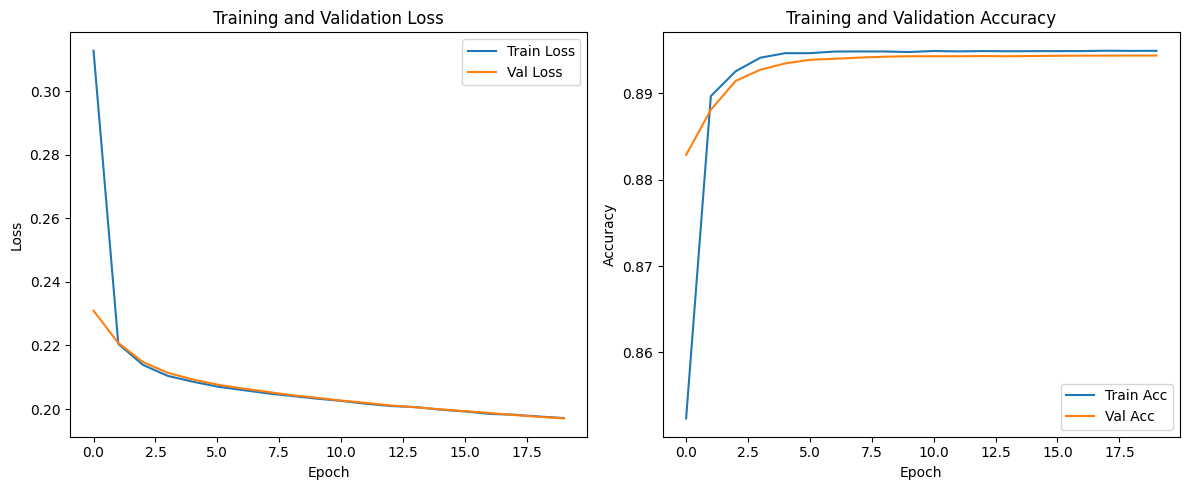

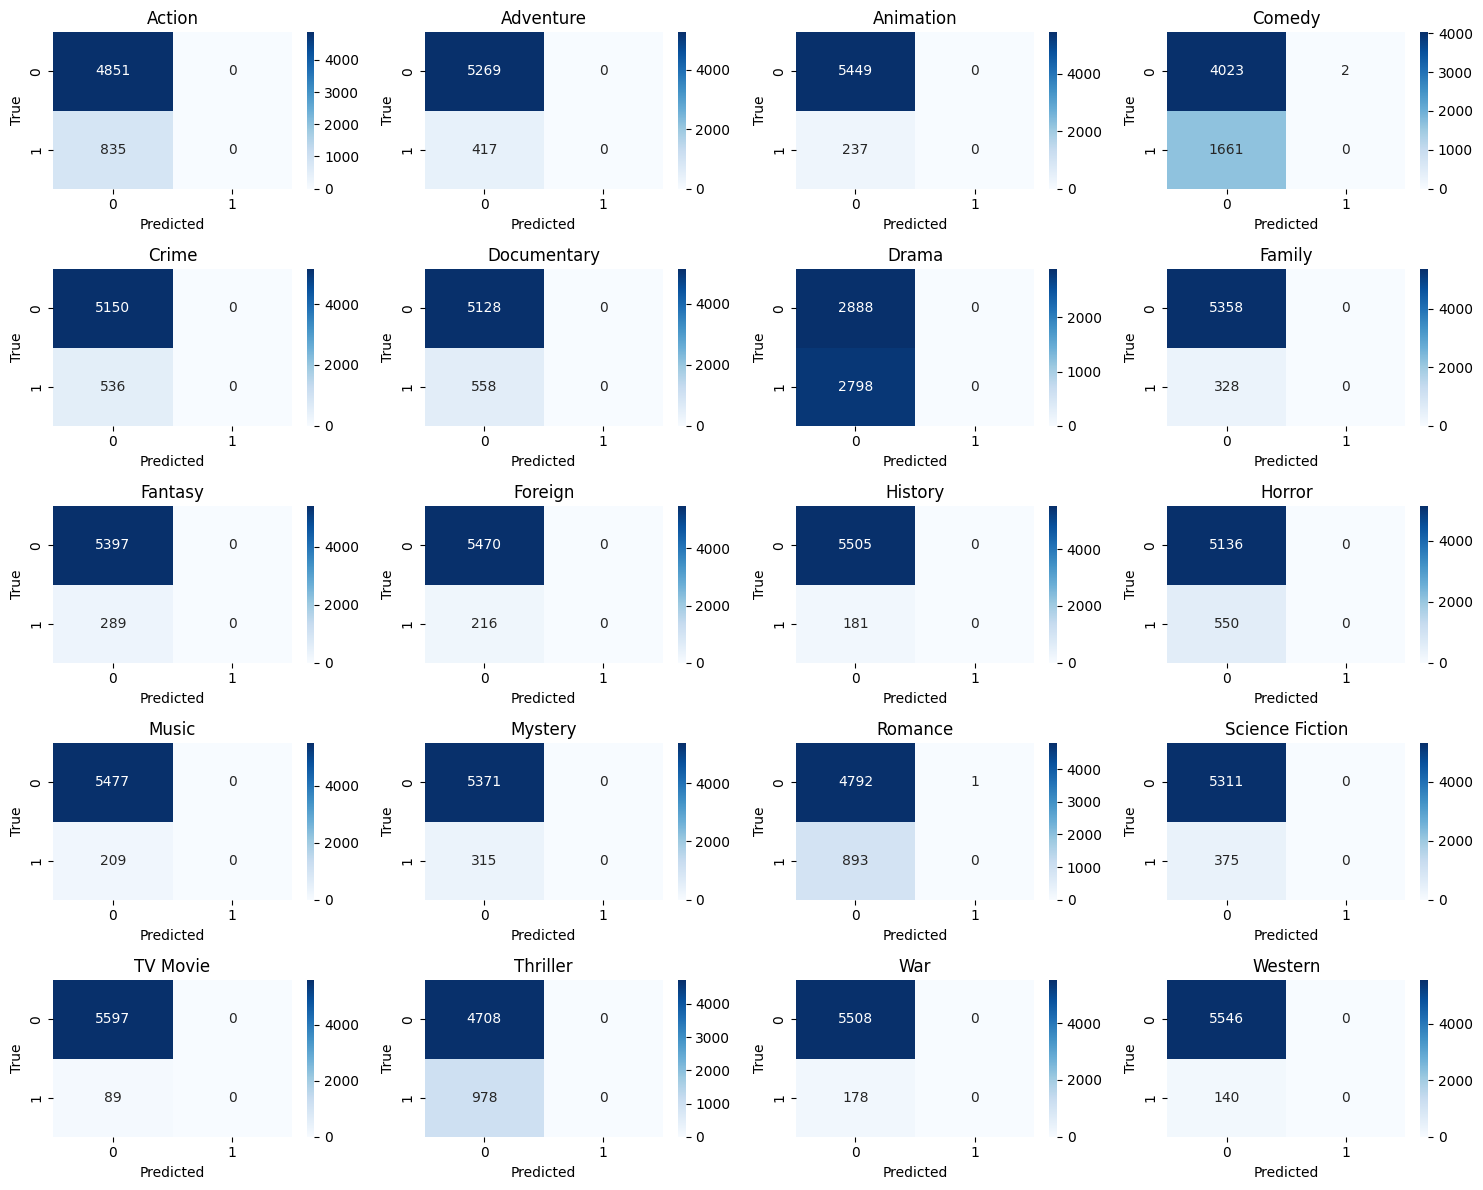

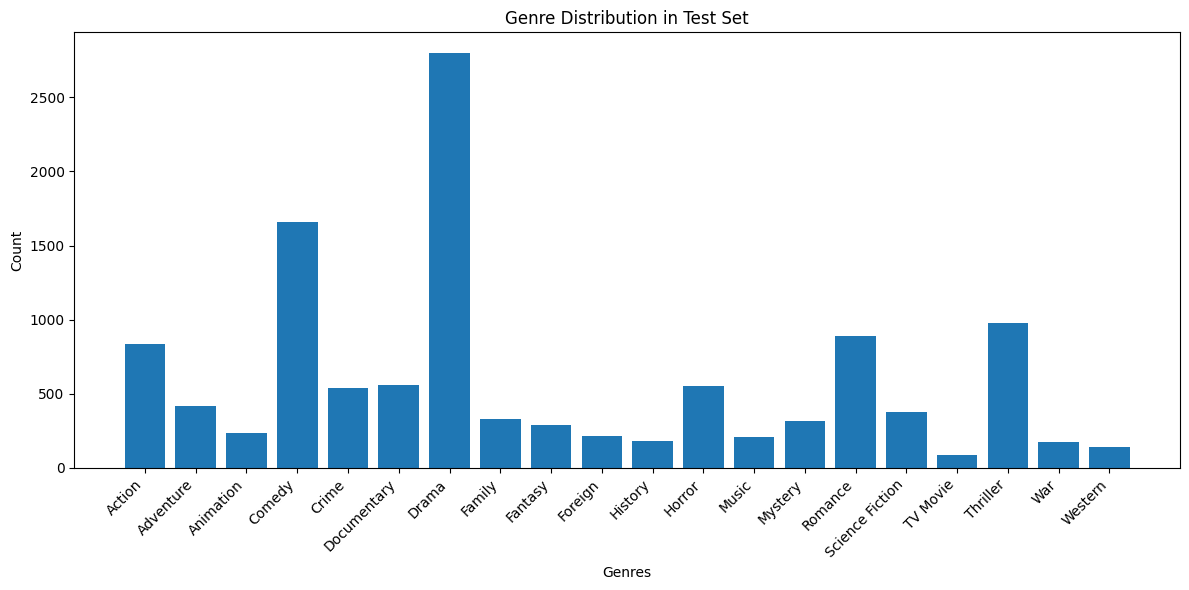

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import os

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Set device: using MPS if available (on Mac), otherwise CUDA if available, else CPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Load and preprocess data
df = pd.read_csv('filtered_movies.csv', sep='|')
df = df.dropna(subset=['Overview', 'Genre'])
df = df[df['Overview'].str.strip() != '']
df = df[df['Genre'].str.strip() != '']
print(f"Dataset size after cleaning: {len(df)} rows")

df['Genre'] = df['Genre'].apply(lambda x: [g.strip() for g in x.split(',')])
mlb = MultiLabelBinarizer()
genre_labels = mlb.fit_transform(df['Genre'])
genre_classes = mlb.classes_
print(f"Genres detected: {list(genre_classes)}")

genre_counts_dict = {
    'Animation': 1599, 'Comedy': 11309, 'Family': 2305, 'Adventure': 2891, 'Fantasy': 1866,
    'Romance': 6159, 'Action': 5584, 'Crime': 3769, 'Drama': 18449, 'Thriller': 6677,
    'History': 1286, 'Science Fiction': 2455, 'War': 1183, 'Mystery': 2156, 'Foreign': 1501,
    'Music': 1426, 'Horror': 3707, 'Documentary': 3641, 'Western': 905, 'TV Movie': 679
}
missing_genres = set(genre_classes) - set(genre_counts_dict.keys())
if missing_genres:
    print(f"Warning: Genres {missing_genres} not in provided counts. Assigning default count of 1.")
    for genre in missing_genres:
        genre_counts_dict[genre] = 1

def tokenize_text(text, max_len=100):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='pt'  # Return PyTorch tensors
    )
    return {
        'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dimension
        'attention_mask': encoding['attention_mask'].squeeze(0)
    }

# Preprocess data by encoding texts
encoded_texts = [tokenize_text(overview, max_len=100) for overview in df['Overview']]
print(f"Encoded texts length: {len(encoded_texts)}")

X_train, X_temp, y_train, y_temp = train_test_split(encoded_texts, genre_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

# Dataset and DataLoader
class MovieDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings[idx]['input_ids'],
            'attention_mask': self.encodings[idx]['attention_mask'],
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

train_dataset = MovieDataset(X_train, y_train)
val_dataset = MovieDataset(X_val, y_val)
test_dataset = MovieDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Class weights for imbalance adjustment
genre_counts_array = np.array([genre_counts_dict[g] for g in genre_classes])
class_weights = 1.0 / (genre_counts_array + 1e-6)
class_weights = class_weights / class_weights.sum() * len(genre_classes)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights.to(device)

# BERT-based Model for Movie Classification
class MovieBERT(nn.Module):
    def __init__(self, num_genres, dropout_rate=0.3):
        super(MovieBERT, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(768, num_genres)  # BERT's hidden size is 768
    
    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        with torch.no_grad():  # Freeze BERT weights. Remove this to fine-tune BERT.
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # [CLS] token embedding
        output = self.dropout(pooled_output)
        output = self.fc(output)
        return output

num_genres = len(genre_classes)
model = MovieBERT(num_genres)
model.to(device)

# Training with early stopping
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=2e-5)  # Typical LR for BERT fine-tuning
num_epochs = 20
patience = 5
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == labels).float().sum().item()
        train_total += labels.numel()
    
    train_loss = total_train_loss / len(train_loader)
    train_acc = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    model.eval()
    total_val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).float().sum().item()
            val_total += labels.numel()
    
    val_loss = total_val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'bert_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Load best model
model.load_state_dict(torch.load('bert_model.pt'))

# Test evaluation
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids, attention_mask)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        test_preds.append(preds.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_preds = np.vstack(test_preds)
test_labels = np.vstack(test_labels)
test_acc = (test_preds == test_labels).mean()
print(f'Test Accuracy: {test_acc:.4f}')

# Visualizations
os.makedirs('plots', exist_ok=True)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.savefig('plots/train_val_metrics.png')
plt.show()

plt.figure(figsize=(15, 12))
for i, genre in enumerate(genre_classes):
    cm = confusion_matrix(test_labels[:, i], test_preds[:, i])
    plt.subplot(5, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{genre}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.savefig('plots/confusion_matrices.png')
plt.show()

test_genre_counts = test_labels.sum(axis=0)
plt.figure(figsize=(12, 6))
plt.bar(genre_classes, test_genre_counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Genre Distribution in Test Set')
plt.tight_layout()
plt.savefig('plots/test_genre_distribution.png')
plt.show()

gpt model


Using device: mps
Dataset size after cleaning: 37904 rows
Genres detected: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
Encoded texts length: 37904
Train size: 26532, Val size: 5686, Test size: 5686
Epoch 1: Train Loss: 0.7784, Train Acc: 0.7121, Val Loss: 0.3469, Val Acc: 0.8435
Epoch 2: Train Loss: 0.3132, Train Acc: 0.8607, Val Loss: 0.2764, Val Acc: 0.8902
Epoch 3: Train Loss: 0.2620, Train Acc: 0.8843, Val Loss: 0.2622, Val Acc: 0.8929
Epoch 4: Train Loss: 0.2452, Train Acc: 0.8904, Val Loss: 0.2506, Val Acc: 0.8937
Epoch 5: Train Loss: 0.2342, Train Acc: 0.8932, Val Loss: 0.2406, Val Acc: 0.8941
Epoch 6: Train Loss: 0.2266, Train Acc: 0.8941, Val Loss: 0.2326, Val Acc: 0.8943
Epoch 7: Train Loss: 0.2218, Train Acc: 0.8946, Val Loss: 0.2265, Val Acc: 0.8944
Epoch 8: Train Loss: 0.2184, Train Acc: 0.8947,

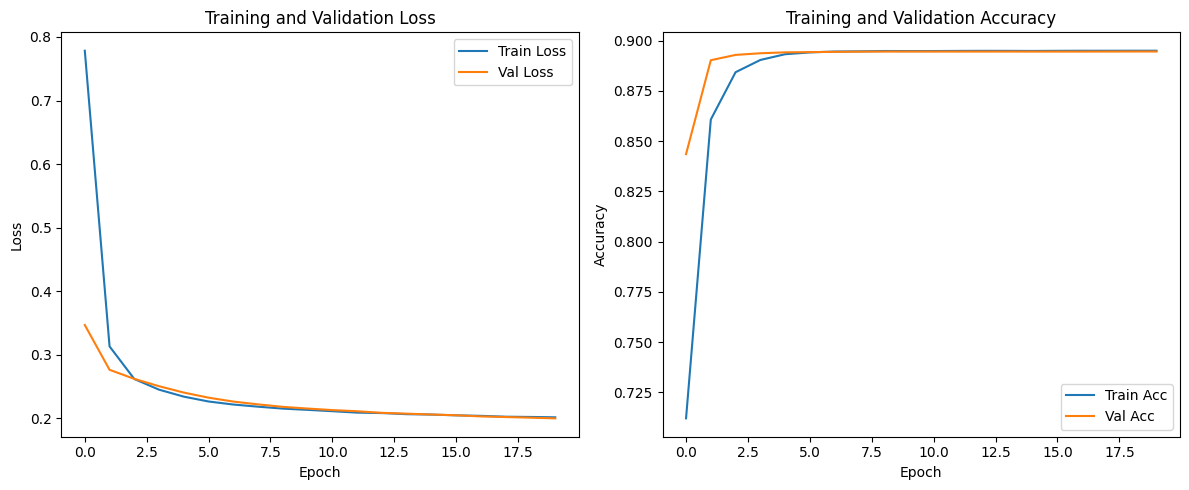

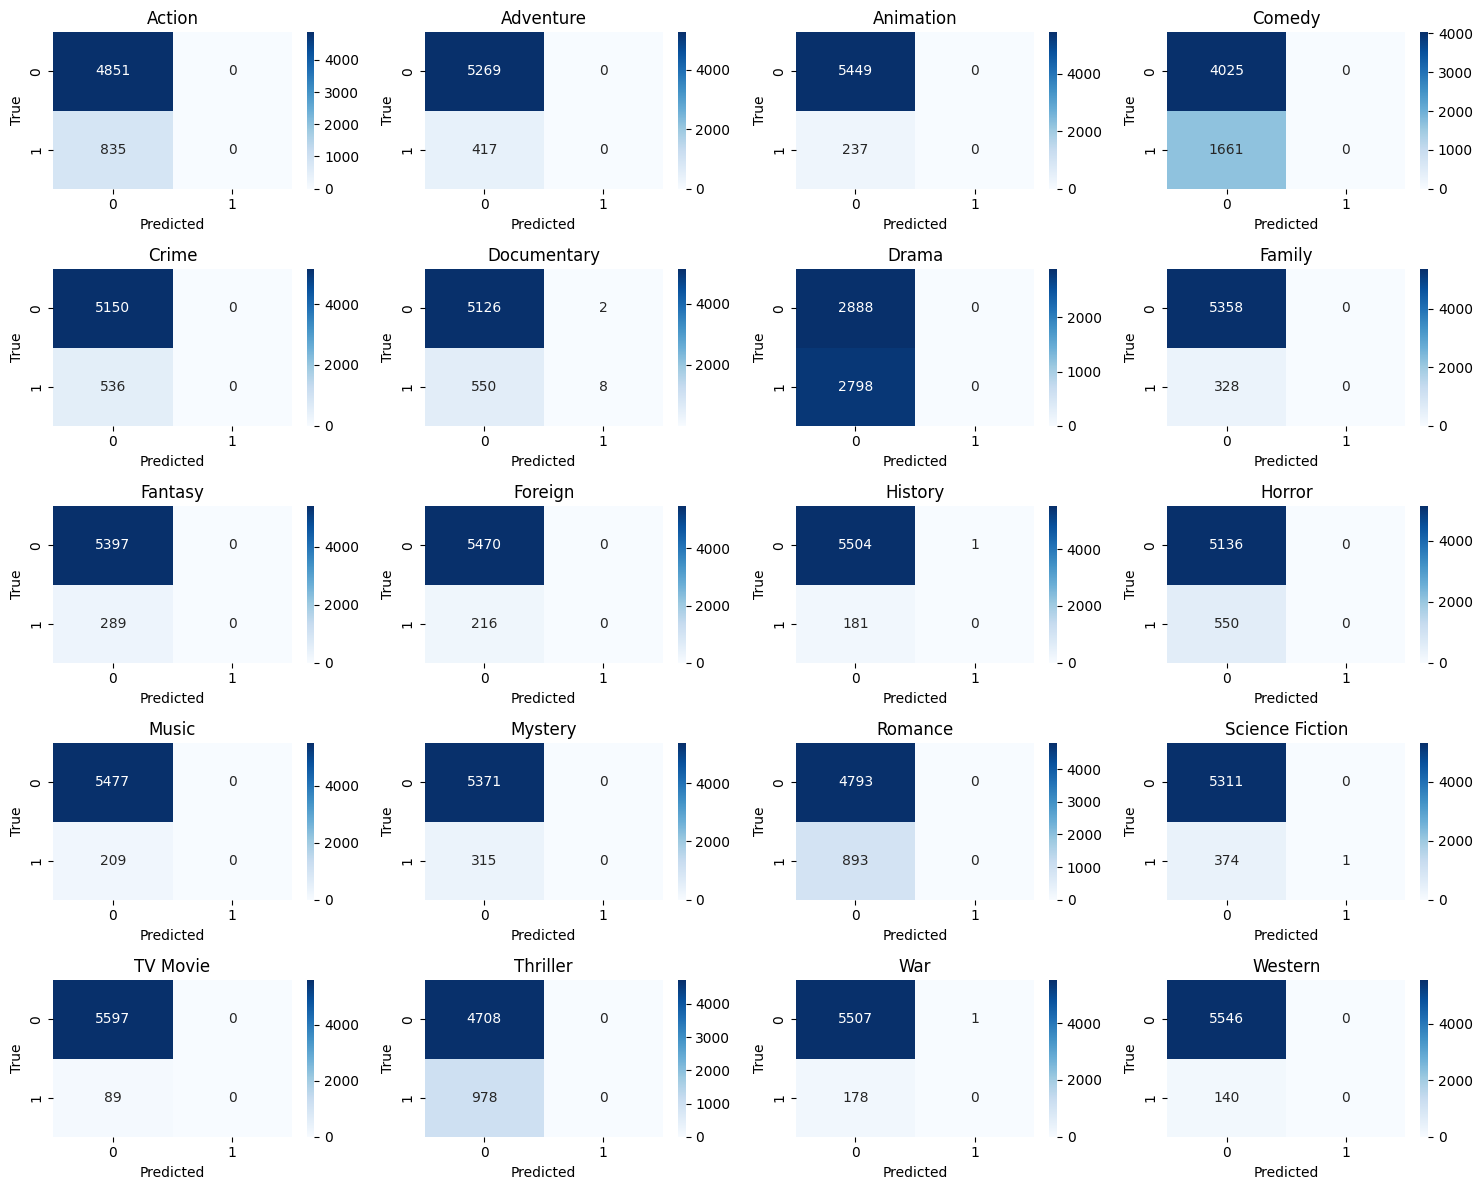

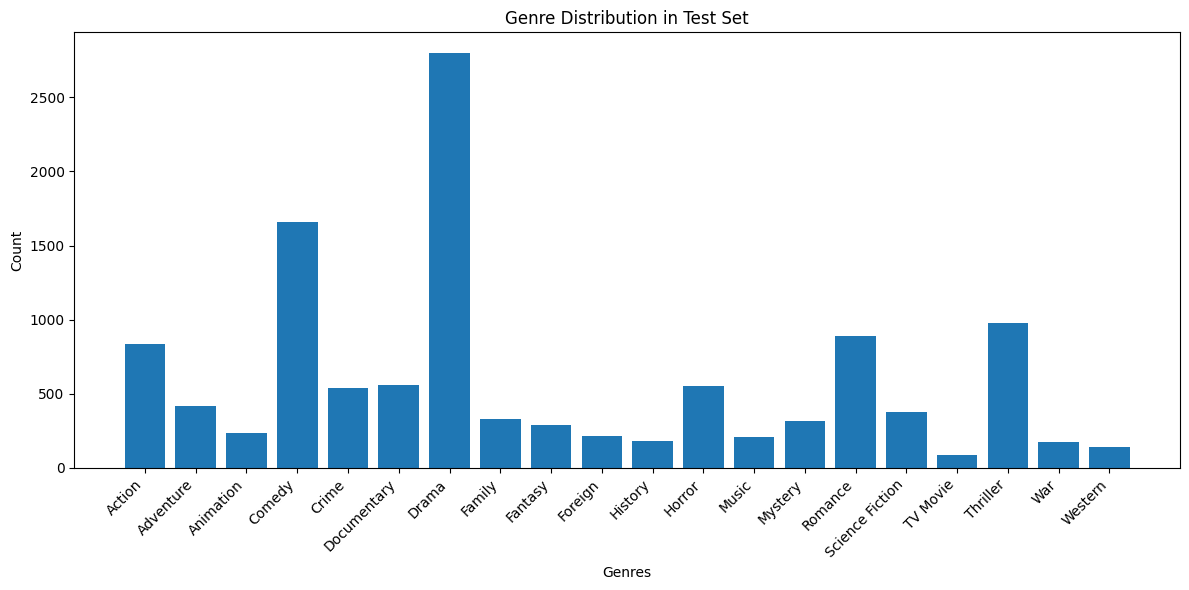

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2Tokenizer, GPT2Model
import os

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Set device: MPS if available (Mac), otherwise CUDA, else CPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2Model.from_pretrained('gpt2')

# GPT-2 doesn’t have a pad token by default, so we set one
tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as padding
tokenizer.padding_side = 'left'  # GPT-2 typically processes sequences from left to right

# Load and preprocess data
df = pd.read_csv('filtered_movies.csv', sep='|')
df = df.dropna(subset=['Overview', 'Genre'])
df = df[df['Overview'].str.strip() != '']
df = df[df['Genre'].str.strip() != '']
print(f"Dataset size after cleaning: {len(df)} rows")

df['Genre'] = df['Genre'].apply(lambda x: [g.strip() for g in x.split(',')])
mlb = MultiLabelBinarizer()
genre_labels = mlb.fit_transform(df['Genre'])
genre_classes = mlb.classes_
print(f"Genres detected: {list(genre_classes)}")

genre_counts_dict = {
    'Animation': 1599, 'Comedy': 11309, 'Family': 2305, 'Adventure': 2891, 'Fantasy': 1866,
    'Romance': 6159, 'Action': 5584, 'Crime': 3769, 'Drama': 18449, 'Thriller': 6677,
    'History': 1286, 'Science Fiction': 2455, 'War': 1183, 'Mystery': 2156, 'Foreign': 1501,
    'Music': 1426, 'Horror': 3707, 'Documentary': 3641, 'Western': 905, 'TV Movie': 679
}
missing_genres = set(genre_classes) - set(genre_counts_dict.keys())
if missing_genres:
    print(f"Warning: Genres {missing_genres} not in provided counts. Assigning default count of 1.")
    for genre in missing_genres:
        genre_counts_dict[genre] = 1

def tokenize_text(text, max_len=100):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='pt',  # Return PyTorch tensors
        return_attention_mask=True  # GPT-2 doesn’t strictly need this, but included for compatibility
    )
    return {
        'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dimension
        'attention_mask': encoding['attention_mask'].squeeze(0)
    }

# Preprocess data by encoding texts
encoded_texts = [tokenize_text(overview, max_len=100) for overview in df['Overview']]
print(f"Encoded texts length: {len(encoded_texts)}")

X_train, X_temp, y_train, y_temp = train_test_split(encoded_texts, genre_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

# Dataset and DataLoader
class MovieDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings[idx]['input_ids'],
            'attention_mask': self.encodings[idx]['attention_mask'],
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

train_dataset = MovieDataset(X_train, y_train)
val_dataset = MovieDataset(X_val, y_val)
test_dataset = MovieDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Class weights for imbalance adjustment
genre_counts_array = np.array([genre_counts_dict[g] for g in genre_classes])
class_weights = 1.0 / (genre_counts_array + 1e-6)
class_weights = class_weights / class_weights.sum() * len(genre_classes)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights.to(device)

# GPT-2-based Model for Movie Classification
class MovieGPT2(nn.Module):
    def __init__(self, num_genres, dropout_rate=0.3):
        super(MovieGPT2, self).__init__()
        self.gpt2 = gpt2_model
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(768, num_genres)  # GPT-2 base hidden size is 768
    
    def forward(self, input_ids, attention_mask):
        # Get GPT-2 outputs
        with torch.no_grad():  # Freeze GPT-2 weights. Remove this to fine-tune.
            outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, 768)
        # Use the last token’s embedding (GPT-2 doesn’t have a [CLS] token like BERT)
        pooled_output = last_hidden_state[:, -1, :]  # (batch_size, 768)
        output = self.dropout(pooled_output)
        output = self.fc(output)
        return output

num_genres = len(genre_classes)
model = MovieGPT2(num_genres)
model.to(device)

# Training with early stopping
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=2e-5)  # Typical LR for GPT-2 fine-tuning
num_epochs = 20
patience = 5
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == labels).float().sum().item()
        train_total += labels.numel()
    
    train_loss = total_train_loss / len(train_loader)
    train_acc = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    model.eval()
    total_val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).float().sum().item()
            val_total += labels.numel()
    
    val_loss = total_val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'gpt_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Load best model
model.load_state_dict(torch.load('gpt_model.pt'))

# Test evaluation
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids, attention_mask)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        test_preds.append(preds.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_preds = np.vstack(test_preds)
test_labels = np.vstack(test_labels)
test_acc = (test_preds == test_labels).mean()
print(f'Test Accuracy: {test_acc:.4f}')

# Visualizations
os.makedirs('plots', exist_ok=True)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.savefig('plots/train_val_metrics.png')
plt.show()

plt.figure(figsize=(15, 12))
for i, genre in enumerate(genre_classes):
    cm = confusion_matrix(test_labels[:, i], test_preds[:, i])
    plt.subplot(5, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{genre}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.savefig('plots/confusion_matrices.png')
plt.show()

test_genre_counts = test_labels.sum(axis=0)
plt.figure(figsize=(12, 6))
plt.bar(genre_classes, test_genre_counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Genre Distribution in Test Set')
plt.tight_layout()
plt.savefig('plots/test_genre_distribution.png')
plt.show()

custom tokenizer

Dataset size after cleaning: 37904 rows
Genres detected: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
Train size: 26532, Val size: 5686, Test size: 5686
Vocabulary size: 10000
Encoded texts shape (train): (26532, 100)
Epoch 1: Train Loss: 0.2110, Train Acc: 0.8939, Val Loss: 0.2015, Val Acc: 0.8945
Epoch 2: Train Loss: 0.1949, Train Acc: 0.8959, Val Loss: 0.1913, Val Acc: 0.8955
Epoch 3: Train Loss: 0.1817, Train Acc: 0.8966, Val Loss: 0.1818, Val Acc: 0.8960
Epoch 4: Train Loss: 0.1689, Train Acc: 0.8974, Val Loss: 0.1759, Val Acc: 0.8963
Epoch 5: Train Loss: 0.1567, Train Acc: 0.8987, Val Loss: 0.1711, Val Acc: 0.8971
Epoch 6: Train Loss: 0.1446, Train Acc: 0.9009, Val Loss: 0.1706, Val Acc: 0.8967
Epoch 7: Train Loss: 0.1327, Train Acc: 0.9045, Val Loss: 0.1726, Val Acc: 0.8980
Epoch 8: Train Loss: 0.1201,

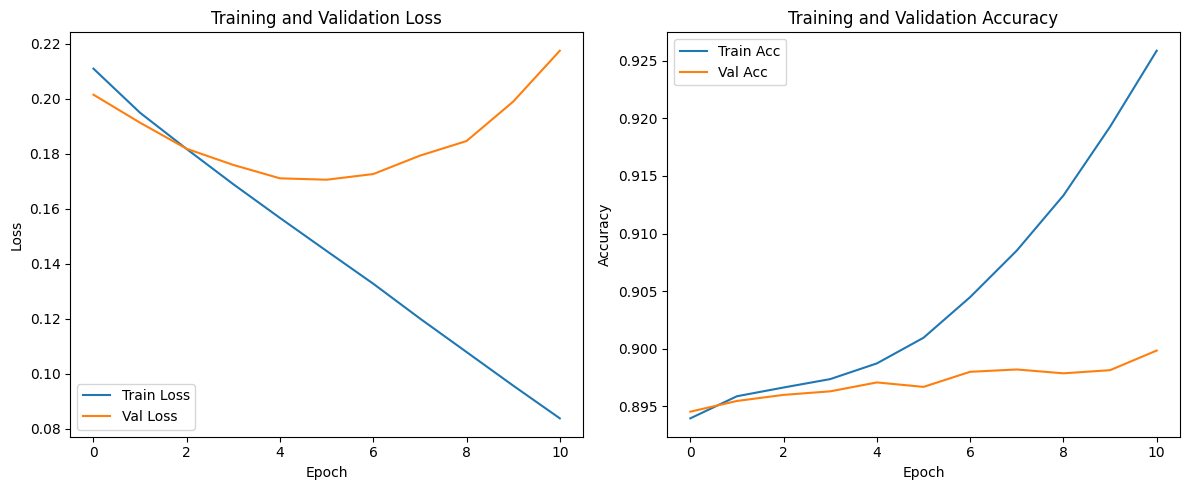

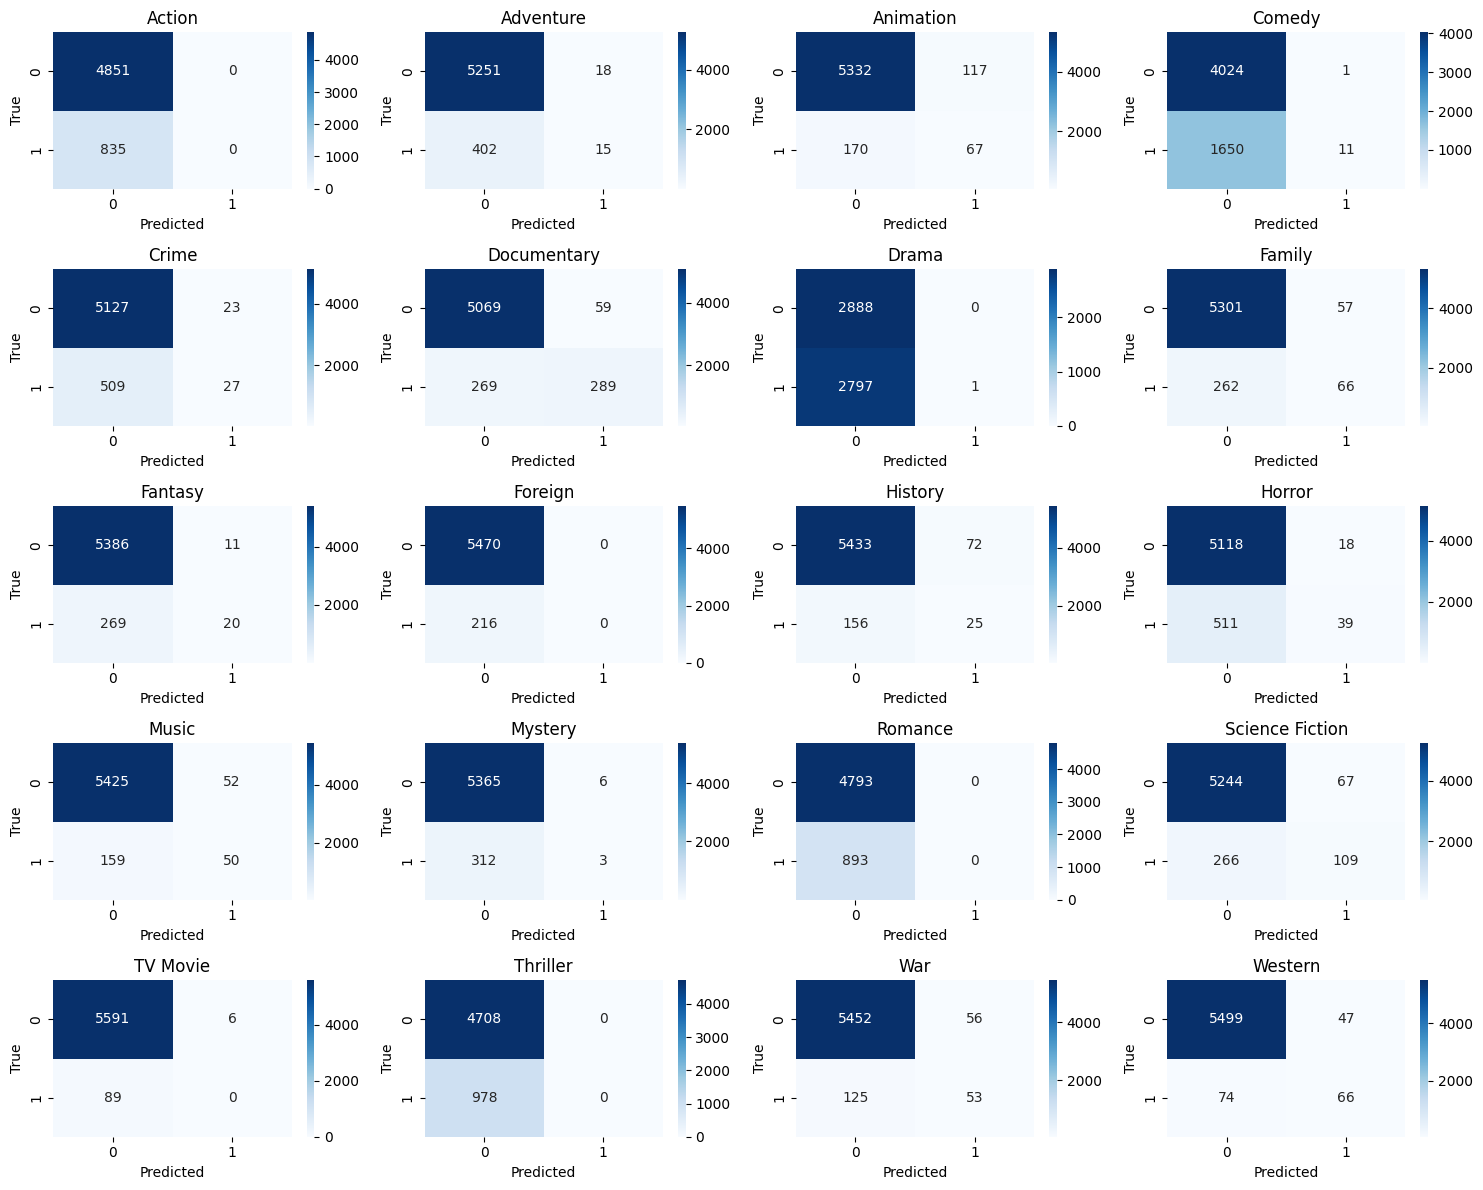

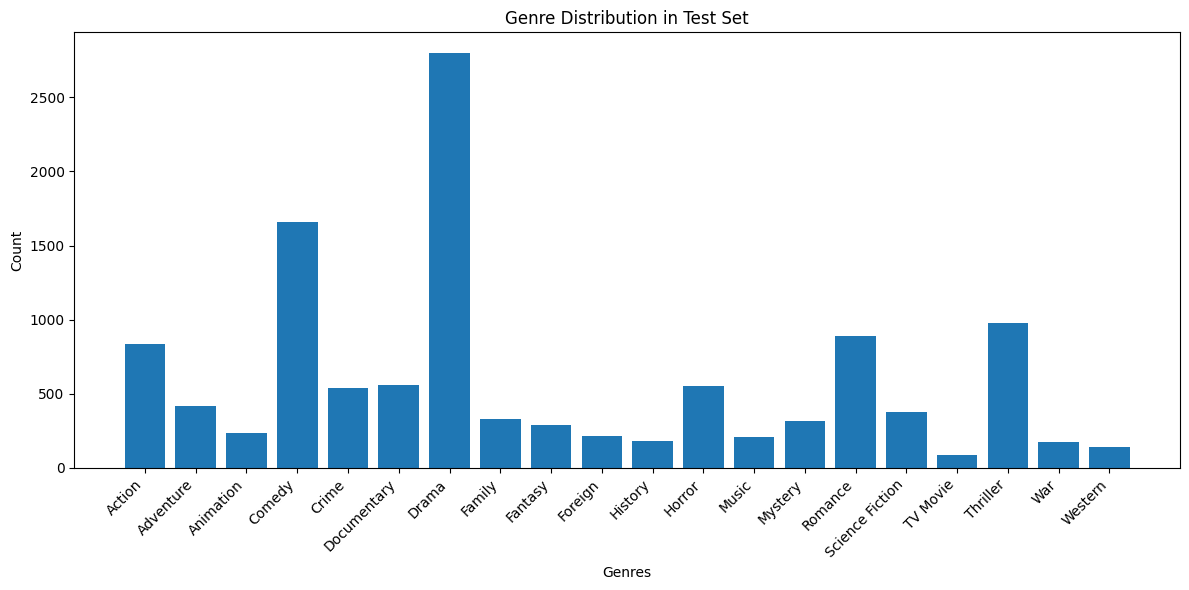

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter

# Set random seed
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Custom Tokenizer Class
class SimpleTokenizer:
    def __init__(self, vocab_size=10000, max_len=100):
        self.vocab_size = vocab_size  # Limit vocabulary to top N frequent words
        self.max_len = max_len
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}  # Predefine PAD and UNK tokens
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
    
    def fit(self, texts):
        # Build vocabulary from a list of texts
        all_words = []
        for text in texts:
            words = self._tokenize(text)
            all_words.extend(words)
        
        # Count word frequencies and take top vocab_size - 2 (excluding PAD, UNK)
        word_counts = Counter(all_words).most_common(self.vocab_size - 2)
        for i, (word, _) in enumerate(word_counts, 2):  # Start index at 2
            self.word2idx[word] = i
            self.idx2word[i] = word
        print(f"Vocabulary size: {len(self.word2idx)}")
    
    def _tokenize(self, text):
        # Basic tokenization: lowercase, remove punctuation, split on whitespace
        text = re.sub(r'[^\w\s]', '', text.lower())
        return text.split()
    
    def encode(self, text):
        # Convert text to list of token indices
        tokens = self._tokenize(text)
        encoded = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]
        # Truncate or pad to max_len
        if len(encoded) > self.max_len:
            encoded = encoded[:self.max_len]
        else:
            encoded = encoded + [self.word2idx['<PAD>']] * (self.max_len - len(encoded))
        return encoded

# Load and preprocess data
df = pd.read_csv('filtered_movies.csv', sep='|')
df = df.dropna(subset=['Overview', 'Genre'])
df = df[df['Overview'].str.strip() != '']
df = df[df['Genre'].str.strip() != '']
print(f"Dataset size after cleaning: {len(df)} rows")

df['Genre'] = df['Genre'].apply(lambda x: [g.strip() for g in x.split(',')])
mlb = MultiLabelBinarizer()
genre_labels = mlb.fit_transform(df['Genre'])
genre_classes = mlb.classes_
print(f"Genres detected: {list(genre_classes)}")

genre_counts_dict = {
    'Animation': 1599, 'Comedy': 11309, 'Family': 2305, 'Adventure': 2891, 'Fantasy': 1866,
    'Romance': 6159, 'Action': 5584, 'Crime': 3769, 'Drama': 18449, 'Thriller': 6677,
    'History': 1286, 'Science Fiction': 2455, 'War': 1183, 'Mystery': 2156, 'Foreign': 1501,
    'Music': 1426, 'Horror': 3707, 'Documentary': 3641, 'Western': 905, 'TV Movie': 679
}
missing_genres = set(genre_classes) - set(genre_counts_dict.keys())
if missing_genres:
    print(f"Warning: Genres {missing_genres} not in provided counts. Assigning default count of 1.")
    for genre in missing_genres:
        genre_counts_dict[genre] = 1

# Split data first, then fit tokenizer on training data only
X_train, X_temp, y_train, y_temp = train_test_split(df['Overview'].tolist(), genre_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

# Initialize and fit tokenizer on training data
tokenizer = SimpleTokenizer(vocab_size=10000, max_len=100)
tokenizer.fit(X_train)

# Encode all splits
encoded_texts_train = np.array([tokenizer.encode(text) for text in X_train])
encoded_texts_val = np.array([tokenizer.encode(text) for text in X_val])
encoded_texts_test = np.array([tokenizer.encode(text) for text in X_test])
print(f"Encoded texts shape (train): {encoded_texts_train.shape}")

# Dataset and DataLoader
class MovieDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return {
            'text': torch.tensor(self.texts[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

train_dataset = MovieDataset(encoded_texts_train, y_train)
val_dataset = MovieDataset(encoded_texts_val, y_val)
test_dataset = MovieDataset(encoded_texts_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Class weights for imbalance adjustment
genre_counts_array = np.array([genre_counts_dict[g] for g in genre_classes])
class_weights = 1.0 / (genre_counts_array + 1e-6)
class_weights = class_weights / class_weights.sum() * len(genre_classes)
class_weights = torch.tensor(class_weights, dtype=torch.float)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = class_weights.to(device)

# Enhanced LSTM Model
class MovieLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_genres, num_layers=2):
        super(MovieLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_genres)  # *2 for bidirectional
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, text):
        embedded = self.embedding(text)
        _, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Concatenate forward and backward hidden states
        output = self.dropout(hidden)
        output = self.fc(output)
        return output

vocab_size = len(tokenizer.word2idx)  # Use custom vocab size
embed_dim = 128
hidden_dim = 256
num_genres = len(genre_classes)
model = MovieLSTM(vocab_size, embed_dim, hidden_dim, num_genres)
model.to(device)

# Training with early stopping
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 20
patience = 5
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0
    for batch in train_loader:
        texts, labels = batch['text'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == labels).float().sum().item()  # Total correct predictions
        train_total += labels.numel()  # Total number of labels
    
    train_loss = total_train_loss / len(train_loader)
    train_acc = train_correct / train_total  # Per-label accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    model.eval()
    total_val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            texts, labels = batch['text'].to(device), batch['label'].to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).float().sum().item()
            val_total += labels.numel()
    
    val_loss = total_val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, ' +
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'custom_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Load best model
model.load_state_dict(torch.load('custom_model.pt'))

# Test evaluation
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        texts, labels = batch['text'].to(device), batch['label'].to(device)
        outputs = model(texts)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        test_preds.append(preds.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_preds = np.vstack(test_preds)
test_labels = np.vstack(test_labels)
test_acc = (test_preds == test_labels).mean()
print(f'Test Accuracy: {test_acc:.4f}')

# Visualizations
os.makedirs('plots', exist_ok=True)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.savefig('plots/train_val_metrics.png')
plt.show()

plt.figure(figsize=(15, 12))
for i, genre in enumerate(genre_classes):
    cm = confusion_matrix(test_labels[:, i], test_preds[:, i])
    plt.subplot(5, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{genre}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.savefig('plots/confusion_matrices.png')
plt.show()

test_genre_counts = test_labels.sum(axis=0)
plt.figure(figsize=(12, 6))
plt.bar(genre_classes, test_genre_counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Genre Distribution in Test Set')
plt.tight_layout()
plt.savefig('plots/test_genre_distribution.png')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from transformers import BertTokenizer

# Updated MovieLSTM model (bidirectional)
class MovieLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_genres, num_layers=2):
        super(MovieLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_genres)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, text):
        embedded = self.embedding(text)
        _, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        output = self.dropout(hidden)
        output = self.fc(output)
        return output

# Tokenization function using BERT tokenizer
def tokenize_text(text, tokenizer, max_len=100):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='np'
    )
    return encoding['input_ids'].flatten()

# Set up BERT tokenizer and model parameters
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
vocab_size = tokenizer.vocab_size

# Genre list and corresponding thresholds (must match training)
genre_classes = [
    "Animation", "Comedy", "Family", "Adventure", "Fantasy",
    "Romance", "Action", "Crime", "Drama", "Thriller",
    "History", "Science Fiction", "War", "Mystery", "Foreign",
    "Music", "Horror", "Documentary", "Western", "TV Movie"
]
num_genres = len(genre_classes)
genre_counts_dict = {
    'Animation': 1599, 'Comedy': 11309, 'Family': 2305, 'Adventure': 2891, 'Fantasy': 1866,
    'Romance': 6159, 'Action': 5584, 'Crime': 3769, 'Drama': 18449, 'Thriller': 6677,
    'History': 1286, 'Science Fiction': 2455, 'War': 1183, 'Mystery': 2156, 'Foreign': 1501,
    'Music': 1426, 'Horror': 3707, 'Documentary': 3641, 'Western': 905, 'TV Movie': 679
}
# Set genre-specific thresholds: threshold=0.2 for rare genres (<2000) else 0.4
thresholds = np.array([0.2 if genre_counts_dict[g] < 2000 else 0.4 for g in genre_classes])
thresholds_tensor = torch.tensor(thresholds, dtype=torch.float)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_dim = 128
hidden_dim = 256

# Load the trained model
model = MovieLSTM(vocab_size, embed_dim, hidden_dim, num_genres)
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.to(device)
model.eval()

def predict_text(text, model, tokenizer, device, max_len=100, genre_labels=None):
    input_ids = tokenize_text(text, tokenizer, max_len)
    input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
    probs = torch.sigmoid(outputs).squeeze().cpu()
    preds = (probs > thresholds_tensor).float()
    results = {genre: prob.item() for genre, prob in zip(genre_labels, probs)} if genre_labels is not None else probs.numpy()
    predicted = [genre for genre, flag in zip(genre_labels, preds) if flag == 1.0] if genre_labels is not None else preds
    if not predicted:
        idx = torch.argmax(probs).item()
        predicted = [genre_labels[idx]]
    return results, predicted

if __name__ == "__main__":
    sample_text = "Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."
    results, predicted_genres = predict_text(sample_text, model, tokenizer, device, genre_labels=genre_classes)
    print("Per-genre probabilities:")
    for genre, prob in results.items():
        print(f"{genre}: {prob:.4f}")
    print("\nFinal predicted genre(s):", predicted_genres)

Per-genre probabilities:
Animation: 0.2743
Comedy: 0.3553
Family: 0.3333
Adventure: 0.2919
Fantasy: 0.0960
Romance: 0.2813
Action: 0.3596
Crime: 0.2536
Drama: 0.2675
Thriller: 0.0856
History: 0.2961
Science Fiction: 0.1120
War: 0.3098
Mystery: 0.0502
Foreign: 0.2019
Music: 0.1746
Horror: 0.0244
Documentary: 0.1190
Western: 0.1408
TV Movie: 0.0486

Final predicted genre(s): ['Animation', 'History', 'War', 'Foreign']
